In [151]:
# %%
import pandas as pd
import numpy as np
from collections import defaultdict


def generate_folds(df, k=5, seed=42):
    """
    Generate label-disjunct folds for each (dataset, model) combination using a local random number generator.

    Args:
    df (pd.DataFrame): Input dataframe with columns 'dataset', 'model', 'label'
    k (int): Number of folds
    seed (int): Random seed for reproducibility

    Returns:
    pd.DataFrame: Copy of input dataframe with an additional 'fold' column
    """
    # Create a copy of the input dataframe
    df_with_folds = df.copy()
    df_with_folds["fold"] = -1  # Initialize fold column

    # Create a local random number generator
    rng = np.random.default_rng(seed)

    # Group by dataset and model
    for (dataset, model), group in df.groupby(["dataset", "model"]):
        # Get unique labels for this group
        unique_labels = group["label"].unique()

        # Shuffle labels using the local RNG
        rng.shuffle(unique_labels)

        # Split labels into k groups
        label_folds = np.array_split(unique_labels, k)

        # Create a mapping from label to fold
        label_to_fold = {}
        for fold, labels in enumerate(label_folds):
            for label in labels:
                label_to_fold[label] = fold

        # Assign folds to rows
        mask = (df_with_folds["dataset"] == dataset) & (df_with_folds["model"] == model)
        df_with_folds.loc[mask, "fold"] = df_with_folds.loc[mask, "label"].map(label_to_fold)

    # Ensure all rows have been assigned a fold
    assert (df_with_folds["fold"] != -1).all(), "Some rows were not assigned a fold"

    return df_with_folds

In [152]:
# %%
import pandas as pd
import numpy as np
from typing import List, Tuple


def split(
    df: pd.DataFrame, k: int = 5, construction_method: str = "equal_classes", seed: int = 42
) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Split the dataframe into k train-test combinations based on the 'fold' column.
    Then applies the specified construction method to create new classes.

    Args:
    df (pd.DataFrame): Input dataframe with 'fold', 'dataset', 'model', and 'label' columns
    k (int): Number of folds (default 5)
    construction_method (str): Method to construct new classes ('equal_classes' or 'equal_images')
    seed (int): Random seed for reproducibility

    Returns:
    List[Tuple[pd.DataFrame, pd.DataFrame]]: List of (train, test) dataframe pairs
    """
    assert "fold" in df.columns, "Dataframe must have a 'fold' column"
    assert "dataset" in df.columns and "model" in df.columns, "Dataframe must have 'dataset' and 'model' columns"
    assert "label" in df.columns, "Dataframe must have a 'label' column"
    assert (
        len(df["dataset"].unique()) == 1 and len(df["model"].unique()) == 1
    ), "Dataframe should contain only one dataset and model combination"
    MIN_SAMPLES_REMAINING = 1
    rng = np.random.default_rng(seed)

    splits = []
    for i in range(k):
        test_df = df[df["fold"] == i].copy()
        test_df["is_new"] = True
        train_df = df[df["fold"] != i].copy()
        train_df["is_new"] = False

        if construction_method == "equal_classes":
            """
            Choose a random number of labels from train_df to move to test_df.
            Sample upto max_samples from each label. Skip if the label has less than min_samples.
            """
            n = int(np.mean([train_df[train_df["fold"] == j]["label"].nunique() for j in range(k) if j != i]))
            min_samples, max_samples = 1, 3

            train_labels = train_df["label"].unique()
            labels_to_move = rng.choice(train_labels, size=min(n, len(train_labels)), replace=False)

            for label in labels_to_move:
                train_label_group = train_df[train_df["label"] == label]
                n_samples = len(train_label_group)
                if n_samples < min_samples + MIN_SAMPLES_REMAINING:
                    print(
                        f"WARNING: Cannot move samples from train_df to test_df because label '{label}' has too few samples (total {n_samples} < {min_samples} + {MIN_SAMPLES_REMAINING})."
                    )
                    continue
                n_samples_to_move = min(max_samples, n_samples - MIN_SAMPLES_REMAINING)
                samples_to_move = train_label_group.sample(n=n_samples_to_move, random_state=rng)
                train_df = train_df.drop(samples_to_move.index)
                test_df = pd.concat([test_df, samples_to_move], ignore_index=True)

        elif construction_method == "equal_images":
            """
            Choose a random number of images from train_df to move to test_df.
            Ensure that at least one image from each label remains in train_df.
            """
            n_images_to_move = len(test_df)
            train_labels = train_df["label"].unique()

            # Randomly sample images from train_df
            samples_to_move = train_df.sample(n=n_images_to_move, random_state=rng)

            # Ensure at least one image from each label remains in train_df
            for label in train_labels:
                label_samples = samples_to_move[samples_to_move["label"] == label]
                if len(label_samples) == len(train_df[train_df["label"] == label]):
                    # If all samples of a label are selected to move, keep one in train_df
                    sample_to_keep = label_samples.sample(n=1, random_state=rng)
                    samples_to_move = samples_to_move.drop(sample_to_keep.index)

            # Move selected samples from train_df to test_df
            train_df = train_df.drop(samples_to_move.index)
            samples_to_move["is_new"] = True
            test_df = pd.concat([test_df, samples_to_move], ignore_index=True)

        else:
            raise ValueError(f"Unknown construction method: {construction_method}")

        splits.append((train_df, test_df))

    return splits

In [153]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(y_true, y_pred, unique_labels):
    """
    Compute accuracy and macro F1-score for new vs. known classification and multiclass classification among known classes.
    New Class has label -1. The other classes are multiclass.

    Args:
    y_true (array-like): True labels
    y_pred (array-like): Predicted labels
    unique_labels (array-like): List of known class labels

    Returns:
    dict: Dictionary containing computed metrics


    T|F
    1|1 - Correct
    1|2 - Incorrect known
    1|-1 - Incorrect new & new vs. known
    -1|1 - Incorrect known & new vs. known
    -1|-1 - Correct new

    multiclass -> always correct if left equal to right side (no matter if new or known class, it's just classification over n+1)
    """
    # Convert to numpy arrays for easier manipulation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Create binary labels for new vs. known classification
    y_true_binary = (y_true == -1).astype(int)
    y_pred_binary = (y_pred == -1).astype(int)

    # Compute metrics for binary classification (new vs. known)
    binary_accuracy = accuracy_score(y_true_binary, y_pred_binary)
    binary_f1 = f1_score(y_true_binary, y_pred_binary)

    # Compute metrics for multiclass classification (only for known classes)
    mask_true = y_true != -1
    mask_pred = y_pred != -1
    mask = mask_true & mask_pred

    # TODO(liamvdv): reconsider if this is the behaviour we want when no match is found. i.d.R. we want NOT to pick this as max, thus assign low precision.
    only_known_accuracy = accuracy_score(y_true[mask], y_pred[mask]) if y_true[mask].size > 0 else 0

    # we will not add the '-1' new class to the labels; this f1 is only about the known classes
    # we want to exclude the 'new' class from the f1 calculation via labels= (note we are not using the mask here)
    # this will give us the f1 score over the known classes only [zero_division=1 is used to allow labels to be missing]
    only_known_f1 = f1_score(y_true, y_pred, labels=unique_labels, average="macro", zero_division=1)

    # Create a dictionary to store the metrics
    metrics = {
        # how often was new class predicted correctly
        # threshold graph: should start at 1 and go down to 0
        "new_vs_all_accuracy": binary_accuracy,
        # threshold graph: should start at 1 and go down to 0
        "new_vs_all_f1": binary_f1,
        # t=-1 or p=-1 will be excluded
        "only_known_accuracy": only_known_accuracy,
        "only_known_f1": only_known_f1,
        # normal multiclass over n+1 classes
        # threshold graph: should start at
        "multiclass_accuracy": accuracy_score(y_true, y_pred),
        "multiclass_f1": f1_score(y_true, y_pred, average="macro"),
        "multiclass_f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }

    return metrics

In [154]:
import math
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from typing import List, Dict
from scipy.spatial.distance import cdist


def knn_openset_recognition(
    dataset: pd.DataFrame,
    queryset: pd.DataFrame,
    thresholds: List[float],
    method: str = "knn1",
    snapshot: List[float] = None,
) -> Dict[float, Dict[str, float]]:
    """
    Perform KNN + threshold grid search for open-set recognition with centroid caching.

    Args:
    dataset (pd.DataFrame): Training dataset with 'label' and 'embedding' columns
    queryset (pd.DataFrame): Query dataset with 'label' and 'embedding' columns
    thresholds (List[float]): List of thresholds to search
    method (str): Method to use for classification ('knn1', 'knn5', 'knn1centroid', 'knn1centroid_iqr')
    snapshot (List[float]): List of thresholds to store results for.

    Returns:
    Dict[float, Dict[str, float]]: Results for each threshold
    """
    # Prepare the data
    X_train = np.stack(dataset["embedding"].values)
    y_train = dataset["label"].values
    X_query = np.stack(queryset["embedding"].values)
    y_query = queryset["label"].values

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_query_scaled = scaler.transform(X_query)

    # Fit the NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=5).fit(X_train_scaled)

    # Find the nearest neighbors for queryset
    distances, indices = nbrs.kneighbors(X_query_scaled)

    # Cache for centroids
    centroid_cache = {}

    def get_centroids(method):
        if method not in centroid_cache:
            if method == "knn1centroid":
                centroid_cache[method] = dataset.groupby("label").apply(calculate_centroid, include_groups=False)
            elif method == "knn1centroid_iqr":
                centroid_cache[method] = dataset.groupby("label").apply(
                    calculate_centroid_with_iqr, include_groups=False
                )
        return centroid_cache[method]

    results = {}
    for t in thresholds:
        if method == "knn1":
            predictions = knn1(dataset, indices, distances, t)
        elif method == "knn5":
            predictions = knnK(dataset, indices, distances, t)
        elif method == "knn5distance":
            predictions = knn_distance(dataset, indices, distances, t)
        elif method in ["knn1centroid", "knn1centroid_iqr"]:
            centroids = get_centroids(method)
            predictions = knn1centroid_generic(dataset, indices, distances, t, centroids)
        else:
            raise ValueError(f"Unknown method: {method}")

        results[t] = compute_metrics(y_query, predictions, dataset["label"].unique())

        if snapshot and any(s for s in snapshot if math.isclose(t, s, abs_tol=1e-6)):
            results[t]["y_true"] = y_query
            results[t]["y_pred"] = predictions

    return results


def calculate_centroid(group):
    """Calculate the centroid of a group of embeddings."""
    embeddings = np.vstack(group["embedding"].values)
    return np.mean(embeddings, axis=0) if embeddings.size > 0 else np.zeros(embeddings.shape[1])


def calculate_centroid_with_iqr(group):
    """Calculate the centroid of a group of embeddings with IQR-based outlier filtering."""
    embeddings = filter_outliers_iqr(pd.DataFrame(np.vstack(group["embedding"]))).values
    return np.mean(embeddings, axis=0) if embeddings.size > 0 else np.zeros(group["embedding"].iloc[0].shape)


def filter_outliers_iqr(group):
    """Filter outliers using the Interquartile Range method."""
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group >= lower_bound) & (group <= upper_bound)]


def knn1centroid_generic(dataset, indices, distances, threshold, centroids):
    """
    Perform 1-NN classification using pre-computed centroids of each class.

    Args:
    dataset (pd.DataFrame): Training dataset with 'label' and 'embedding' columns
    indices (np.array): Indices of nearest neighbors for each query point
    distances (np.array): Distances to nearest neighbors for each query point
    threshold (float): Distance threshold for classification
    centroids (pd.Series): Pre-computed centroids for each class

    Returns:
    np.array: Predicted labels
    """
    query_embeddings = np.vstack(dataset.iloc[indices[:, 0]]["embedding"].values)
    centroid_distances = cdist(query_embeddings, np.vstack(centroids.values))

    nearest_centroid_indices = np.argmin(centroid_distances, axis=1)
    nearest_centroid_distances = np.min(centroid_distances, axis=1)

    predictions = np.array(centroids.index[nearest_centroid_indices])
    predictions[nearest_centroid_distances > threshold] = -1

    return predictions


def knn1(dataset, indices, distances, threshold):
    return knnK(dataset, indices[:, :1], distances[:, :1], threshold)


def knnK(dataset, indices, distances, threshold):
    """note: k is implicitly set to indices.shape[1]"""
    predictions = []
    for idx, dist in zip(indices, distances):
        valid = dataset.iloc[idx][dist <= threshold]
        if not valid.empty:
            prediction = valid["label"].mode()[0]
        else:
            prediction = -1
        predictions.append(prediction)
    return np.array(predictions)


def knn_distance(dataset, indices, distances, threshold):
    """note: k is implicitly set to indices.shape[1]"""
    predictions = []
    for idx, dist in zip(indices, distances):
        if dist[0] > threshold:
            predictions.append(-1)
        else:
            weights = 1 / (1 + dist)
            labels = dataset.iloc[idx]["label"]
            df = pd.DataFrame({"label": labels, "weight": weights})
            weighted_votes = df.groupby("label")["weight"].sum()
            predictions.append(weighted_votes.idxmax())
    return np.array(predictions)

In [165]:
def run_knn_openset_recognition_cv(
    thresholds: List[float],
    df: pd.DataFrame,
    k_fold: int = 5,
    construction_method: str = "equal_classes",
    seed: int = 42,
    method: str = "knn1",
    snapshots: List[float] = None,
) -> Dict[float, Dict[str, List[float]]]:
    """
    Run KNN open-set recognition with cross-validation.

    Args:
    df (pd.DataFrame): Input dataframe
    k_fold (int): Number of folds for cross-validation
    n, min_samples, max_samples, seed: Parameters for the split function
    thresholds (List[float]): List of thresholds to search
    knn_k (int): Number of neighbors for KNN
    method (str): KNN method to use

    Returns:
    Dict[float, Dict[str, List[float]]]: Cross-validation results for each threshold
    """
    new_label = -1
    assert new_label not in df["label"].unique(), "New label already exists in the dataframe"
    df_foldable = generate_folds(df, k=k_fold, seed=seed)
    splits = split(df_foldable, k=k_fold, construction_method=construction_method, seed=seed)
    print(splits)

    cv_results = defaultdict(lambda: defaultdict(list))
    for train_df, test_df in splits:
        classes_total = test_df["label"].nunique()
        classes_new = test_df[test_df["is_new"]]["label"].nunique()
        images_total = test_df.count()
        images_new = test_df[test_df["is_new"]].count()
        # set all test_df labels to new_label if is_new column set
        test_df.loc[test_df["is_new"], "label"] = new_label
        test_df.loc[test_df["is_new"], "label_string"] = "new"
        fold_results = knn_openset_recognition(train_df, test_df, thresholds, method=method, snapshot=snapshots)
        for t, metrics in fold_results.items():
            for metric, value in metrics.items():
                cv_results[t][metric].append(value)

                cv_results[t]["count_queryset_images_new"].append(images_new)
                cv_results[t]["count_queryset_classes_new"].append(classes_new)
                cv_results[t]["count_queryset_images_total"].append(images_total)
                cv_results[t]["count_queryset_classes_total"].append(classes_total)

    return cv_results


edf = EXT_MERGED_DF

# Filter and prepare the data
df = edf[(edf["dataset"] == "SPAC+min3+max10") & (edf["model"] == "ViT-Finetuned")].reset_index(drop=True)
analysis = analyse_embedding_space(df)
max_distance = analysis["global_max_dist"]
min_distance = analysis["global_min_dist"]
# Set up parameters
thresholds = np.linspace(0, max_distance + 10, 30)
method = "knn1"
cv_results = run_knn_openset_recognition_cv(thresholds, df, method=method, construction_method="equal_classes")

[(                                                    id  \
10   /workspaces/gorillatracker/data/supervised/cxl...   
11   /workspaces/gorillatracker/data/supervised/cxl...   
12   /workspaces/gorillatracker/data/supervised/cxl...   
13   /workspaces/gorillatracker/data/supervised/cxl...   
14   /workspaces/gorillatracker/data/supervised/cxl...   
..                                                 ...   
719  /workspaces/gorillatracker/data/supervised/cxl...   
724  /workspaces/gorillatracker/data/supervised/cxl...   
725  /workspaces/gorillatracker/data/supervised/cxl...   
726  /workspaces/gorillatracker/data/supervised/cxl...   
727  /workspaces/gorillatracker/data/supervised/cxl...   

                                             embedding  label label_string  \
10   [-0.13332079350948334, -0.5706288814544678, 1....      8            8   
11   [0.11184220016002655, -0.16434264183044434, 1....      8            8   
12   [1.6213490962982178, -1.792150855064392, 0.659...      8      

In [156]:
# %%
def test(true, pred):
    results = compute_metrics(true, pred, unique_labels)
    for metric, value in results.items():
        print(f"{metric}: {value}")


# Define our known class labels
unique_labels = [0, 1, 2]

print("Perfect classification")
y_true = np.array([0, 1, 2, -1])
y_pred = np.array([0, 1, 2, -1])
test(y_true, y_pred)

print("\nLabel in Unique not in True nor Pred")
# tricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior. _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
y_true = np.array([0, 1, 1, -1])
y_pred = np.array([0, 1, 1, -1])
test(y_true, y_pred)

print("\nMisclassify a known class as new class")
y_true = np.array([0, 1, 2, -1, -1])
y_pred = np.array([0, 1, 1, -1, 1])
test(y_true, y_pred)

print("\n+Misclassify a known class as a different known")
y_true = np.array([0, 1, 2, -1])
y_pred = np.array([0, 1, 1, -1])
test(y_true, y_pred)


print("\n+asdfasdf")
y_true = np.array([0, 1, 2, 2])
y_pred = np.array([0, 1, 1, -1])
test(y_true, y_pred)

print("\n+Only New")
y_true = np.array([0, 1, 2, -1])
y_pred = np.array([-1, -1, -1, -1])
test(y_true, y_pred)

Perfect classification
new_vs_all_accuracy: 1.0
new_vs_all_f1: 1.0
only_known_accuracy: 1.0
only_known_f1: 1.0
multiclass_accuracy: 1.0
multiclass_f1: 1.0
multiclass_f1_weighted: 1.0

Label in Unique not in True nor Pred
new_vs_all_accuracy: 1.0
new_vs_all_f1: 1.0
only_known_accuracy: 1.0
only_known_f1: 1.0
multiclass_accuracy: 1.0
multiclass_f1: 1.0
multiclass_f1_weighted: 1.0

Misclassify a known class as new class
new_vs_all_accuracy: 0.8
new_vs_all_f1: 0.6666666666666666
only_known_accuracy: 0.6666666666666666
only_known_f1: 0.5
multiclass_accuracy: 0.6
multiclass_f1: 0.5416666666666666
multiclass_f1_weighted: 0.5666666666666667

+Misclassify a known class as a different known
new_vs_all_accuracy: 1.0
new_vs_all_f1: 1.0
only_known_accuracy: 0.6666666666666666
only_known_f1: 0.5555555555555555
multiclass_accuracy: 0.75
multiclass_f1: 0.6666666666666666
multiclass_f1_weighted: 0.6666666666666666

+asdfasdf
new_vs_all_accuracy: 0.75
new_vs_all_f1: 0.0
only_known_accuracy: 0.6666666666

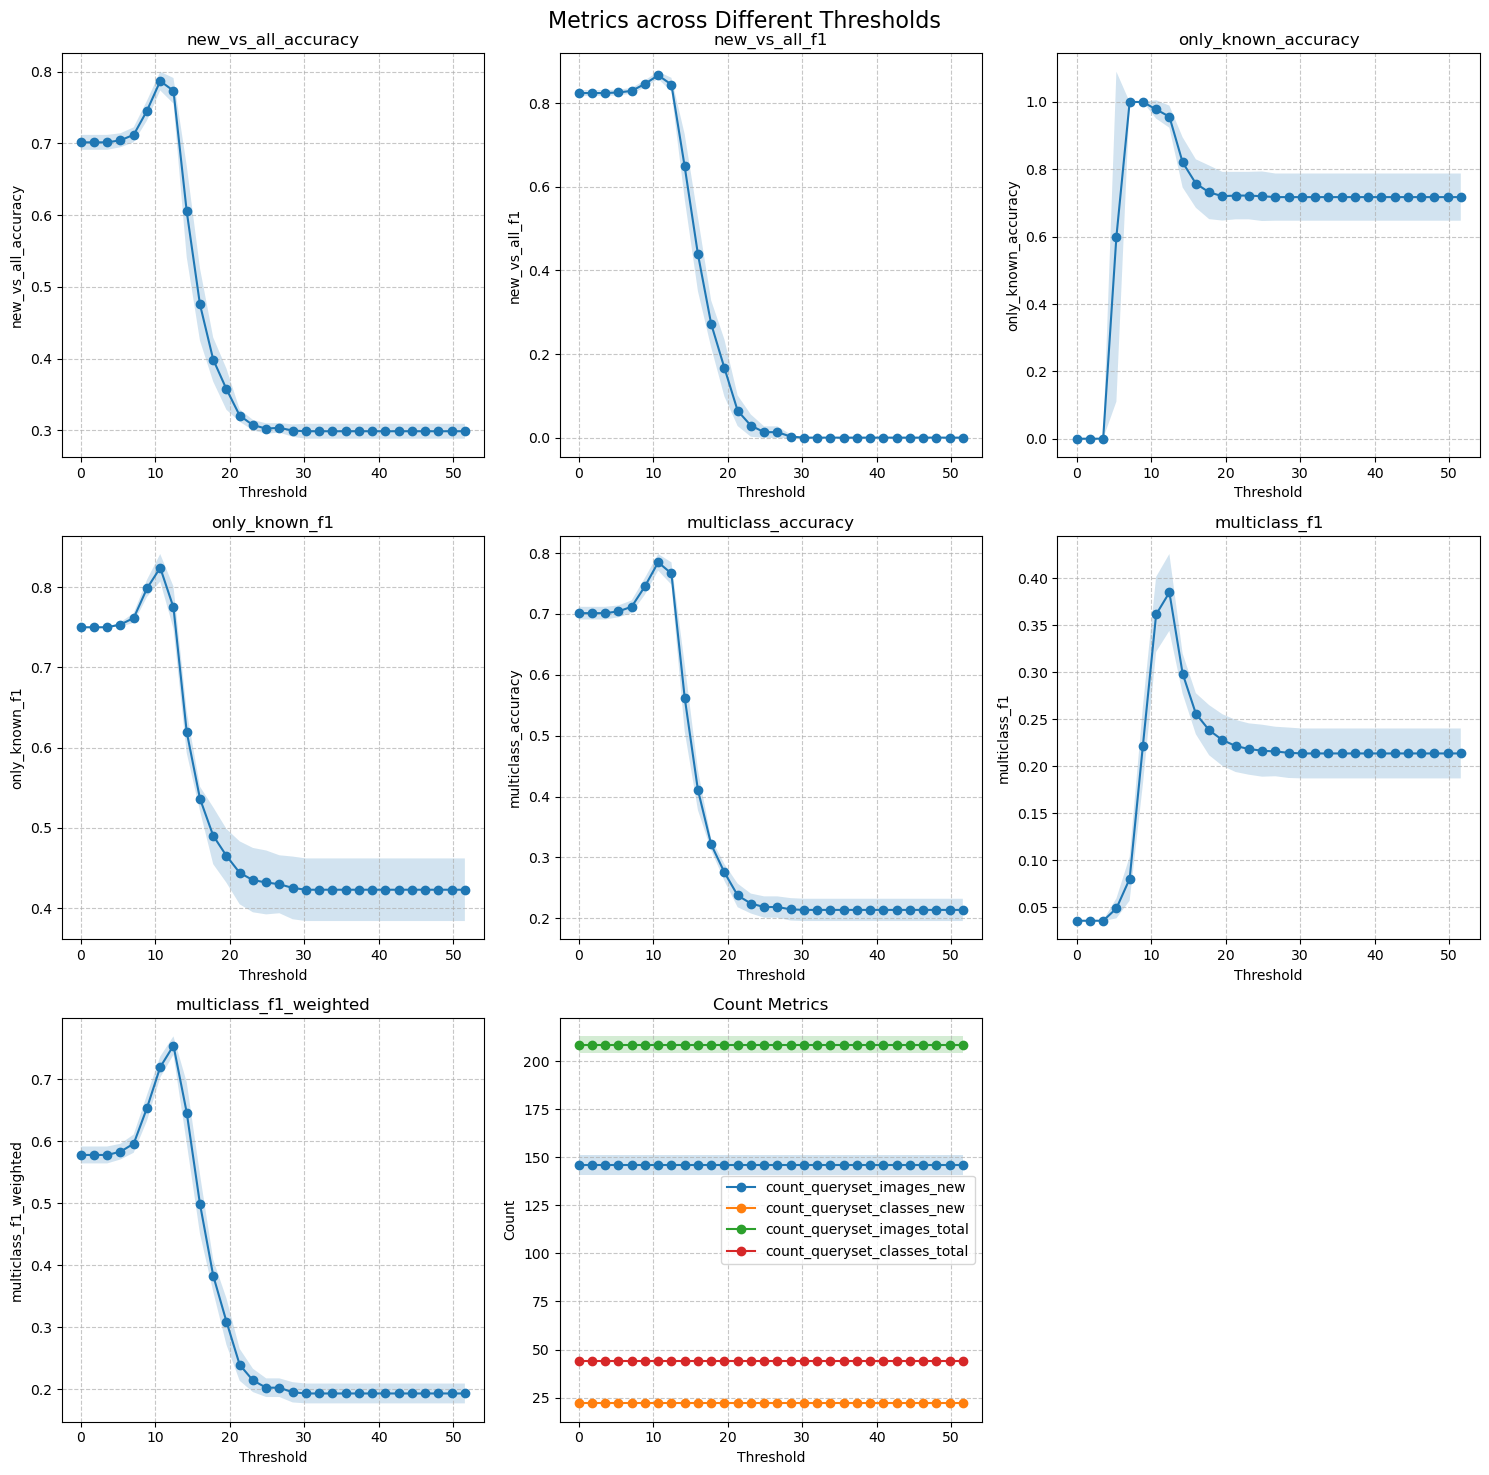

In [157]:
# %%
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List
import math


def visualize_metrics(cv_results: Dict[float, Dict[str, List[float]]], thresholds: List[float]):
    """
    Visualize metrics from cross-validation results, handling None values,
    and combining count_* metrics into a single subplot.

    Args:
    cv_results (Dict[float, Dict[str, List[float]]]): Cross-validation results
    thresholds (List[float]): List of thresholds used

    Returns:
    None (displays the plot)
    """
    metrics = list(cv_results[thresholds[0]].keys())
    count_metrics = [m for m in metrics if m.startswith("count_")]
    other_metrics = [m for m in metrics if not m.startswith("count_")]

    num_metrics = len(other_metrics) + 1  # +1 for the combined count metrics
    num_cols = 3
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    fig.suptitle("Metrics across Different Thresholds", fontsize=16)

    # Flatten axes array for easier indexing
    axes = axes.flatten() if num_rows > 1 else [axes]

    # Plot other metrics
    for i, metric in enumerate(other_metrics):
        ax = axes[i]

        valid_thresholds = []
        mean_values = []
        std_values = []

        for t in thresholds:
            values = [v for v in cv_results[t][metric] if v is not None]
            if values:
                valid_thresholds.append(t)
                mean_values.append(np.mean(values))
                std_values.append(np.std(values))

        if valid_thresholds:
            ax.plot(valid_thresholds, mean_values, marker="o")
            ax.fill_between(
                valid_thresholds,
                [m - s for m, s in zip(mean_values, std_values)],
                [m + s for m, s in zip(mean_values, std_values)],
                alpha=0.2,
            )

        ax.set_xlabel("Threshold")
        ax.set_ylabel(metric)
        ax.set_title(metric)
        ax.grid(True, linestyle="--", alpha=0.7)

    # Plot combined count metrics
    ax = axes[len(other_metrics)]
    ax.set_title("Count Metrics")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Count")

    for metric in count_metrics:
        mean_values = []
        std_values = []

        for t in thresholds:
            values = [v for v in cv_results[t][metric] if v is not None]
            if values:
                mean_values.append(np.mean(values))
                std_values.append(np.std(values))
            else:
                mean_values.append(np.nan)
                std_values.append(np.nan)

        ax.plot(thresholds, mean_values, marker="o", label=metric)
        ax.fill_between(
            thresholds,
            [m - s for m, s in zip(mean_values, std_values)],
            [m + s for m, s in zip(mean_values, std_values)],
            alpha=0.2,
        )

    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.7)

    # Remove any unused subplots
    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


visualize_metrics(cv_results, thresholds)

 ## Metrics

 -1 for new class.

 The threshold will make the new class at first be assigned to too many samples, later at too little (as threshold grows larger that max-cross-point distance)



 multiclass_* look at all classes (including 'new')

 multiclass_accuracy - how often are our predictions correct (compare for same value in true|pred columns)

 multiclass_f1 - is macro weighted: all classes have same importance.

 multiclass_f1_weighted - is weighted by sample count At the start we should see only -1 in resultset, i.e. strong class imbalance.



 only_known_* looks





 new_* looks at '-1' vs rest. It binarizes both columns to 0/1 [actually 1, -1] and then checks for equality.

 new_precision will start at % of non-new images (they are classified wrong, as all have 'new' label).





 => Precision is screwed towards the number of samples. E. g. 50% new / 50% known will place starting precision at 0.5; it will then grow to an optimum.

In [158]:
# %%
import numpy as np
from typing import Dict, List


def get_optimal_threshold(
    cv_results: Dict[float, Dict[str, List[float]]], metric: str = "multiclass_f1", stability_weight: float = 0.2
) -> float:
    """
    Find the optimal threshold based on the cross-validation results.

    Args:
    cv_results (Dict[float, Dict[str, List[float]]]): Cross-validation results
    metric (str): Metric to optimize. Options: 'multiclass_f1', 'new_vs_all_f1', 'only_known_f1'
    stability_weight (float): Weight given to the stability of the metric across folds (0 to 1)

    Returns:
    float: Optimal threshold
    """
    thresholds = list(cv_results.keys())
    scores = []

    for threshold in thresholds:
        metric_values = [v for v in cv_results[threshold][metric] if v is not None]
        if not metric_values:
            scores.append(0.0)
            continue
        mean_score = np.mean(metric_values)
        std_score = np.std(metric_values)

        # Combine mean and stability (inverse of std) into a single score
        combined_score = (1 - stability_weight) * mean_score + stability_weight * (1 / (1 + std_score))
        scores.append(combined_score)

    optimal_index = np.argmax(scores)
    optimal_threshold = thresholds[optimal_index]

    print(f"Optimal threshold for {metric}: {optimal_threshold}")
    mean = np.mean(cv_results[optimal_threshold][metric]) if any(cv_results[optimal_threshold][metric]) else 0
    std = np.std(cv_results[optimal_threshold][metric]) if any(cv_results[optimal_threshold][metric]) else 0
    print(f"Mean {metric} at optimal threshold: {mean:.4f}")
    print(f"Std {metric} at optimal threshold: {std:.4f}")

    return optimal_threshold


optimal_threshold_multiclass = get_optimal_threshold(cv_results, metric="multiclass_f1")

Optimal threshold for multiclass_f1: 12.443514577026756
Mean multiclass_f1 at optimal threshold: 0.3849
Std multiclass_f1 at optimal threshold: 0.0408


In [166]:
# %%
import warnings
from tqdm import tqdm
from gorillatracker.classification.clustering import MERGED_DF, EXT_MERGED_DF
from gorillatracker.classification.metrics import analyse_embedding_space

warnings.filterwarnings("error", category=RuntimeWarning, message="invalid value encountered in scalar divide")

labelling_methods = ["knn1", "knn5", "knn5distance", "knn1centroid", "knn1centroid_iqr"]

construction_methods = {"equal_classes": print, "equal_images": print}


def thresholds_selector(df, n_measures=50):
    analysis = analyse_embedding_space(df)
    max_distance = analysis["global_max_dist"]
    min_distance = analysis["global_min_dist"]
    thresholds = np.concatenate([[0], np.linspace(min_distance, max_distance + 1, n_measures)])
    return thresholds


def sweep_configs(dataframe, configs, resolution=50):
    """make the sweep faster but also less accurate by choosing lower grid search resolution"""
    print(f"Running {len(configs)} configurations at resolution {resolution}...")
    results = {}

    for dataset, model, labelling_method, construction_method in tqdm(configs):
        print(
            f"Started sweep for dataset '{dataset}', model '{model}', "
            f"labelling method '{labelling_method}', and selector method '{construction_method}'"
        )

        # Filter the dataframe for the current dataset and model
        df = dataframe[(dataframe["dataset"] == dataset) & (dataframe["model"] == model)]

        if df.empty:
            print(f"No data found for dataset '{dataset}' and model '{model}'. Skipping...")
            continue
        # Generate thresholds
        thresholds = thresholds_selector(df, n_measures=resolution)
        # Run cross-validation
        cv_results = run_knn_openset_recognition_cv(
            thresholds=thresholds,
            df=df,
            construction_method=construction_method,
            method=labelling_method,
            k_fold=5,
            seed=42,
        )

        # Get optimal threshold
        optimal_threshold = get_optimal_threshold(cv_results, metric="multiclass_f1")

        # Store results
        results[(dataset, model, labelling_method, construction_method)] = {
            "cv_results": cv_results,
            "optimal_threshold": optimal_threshold,
            "thresholds": thresholds,
        }

        print(
            f"Completed sweep for dataset '{dataset}', model '{model}', "
            f"labelling method '{labelling_method}', and selector method '{construction_method}'"
        )

    return results

partial = [("SPAC+min3+max10", "ViT-Finetuned", "knn1centroid", "equal_classes")]
results = sweep_configs(EXT_MERGED_DF, partial, resolution=10)


Running 1 configurations at resolution 10...


  0%|          | 0/1 [00:00<?, ?it/s]

Started sweep for dataset 'SPAC+min3+max10', model 'ViT-Finetuned', labelling method 'knn1centroid', and selector method 'equal_classes'
[(                                                      id  \
12809  /workspaces/gorillatracker/data/supervised/cxl...   
12810  /workspaces/gorillatracker/data/supervised/cxl...   
12811  /workspaces/gorillatracker/data/supervised/cxl...   
12812  /workspaces/gorillatracker/data/supervised/cxl...   
12813  /workspaces/gorillatracker/data/supervised/cxl...   
...                                                  ...   
13518  /workspaces/gorillatracker/data/supervised/cxl...   
13523  /workspaces/gorillatracker/data/supervised/cxl...   
13524  /workspaces/gorillatracker/data/supervised/cxl...   
13525  /workspaces/gorillatracker/data/supervised/cxl...   
13526  /workspaces/gorillatracker/data/supervised/cxl...   

                                               embedding  label label_string  \
12809  [-0.13332079350948334, -0.5706288814544678, 1....    

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]

Optimal threshold for multiclass_f1: 0.0
Mean multiclass_f1 at optimal threshold: 0.2279
Std multiclass_f1 at optimal threshold: 0.0698
Completed sweep for dataset 'SPAC+min3+max10', model 'ViT-Finetuned', labelling method 'knn1centroid', and selector method 'equal_classes'


In [ ]:

labelling_methods = ["knn1", "knn5", "knn5distance", "knn1centroid", "knn1centroid_iqr"]
construction_methods = ["equal_classes", "equal_images"]
df = EXT_MERGED_DF
configs = [
    (dataset, model, labelling_method, construction_method)
    for (dataset, model), _ in df.groupby(["dataset", "model"])
    for labelling_method in labelling_methods
    for construction_method in construction_methods
]
print("Total configurations:", len(configs))
partial = [c for c in configs if c[0] == "SPAC+min3+max10" and c[1] == "ViT-Finetuned"]
print("Partial configurations:", len(partial))
# results = sweep_configs(df, configs, resolution=30)
results = sweep_configs(df, partial, resolution=30)

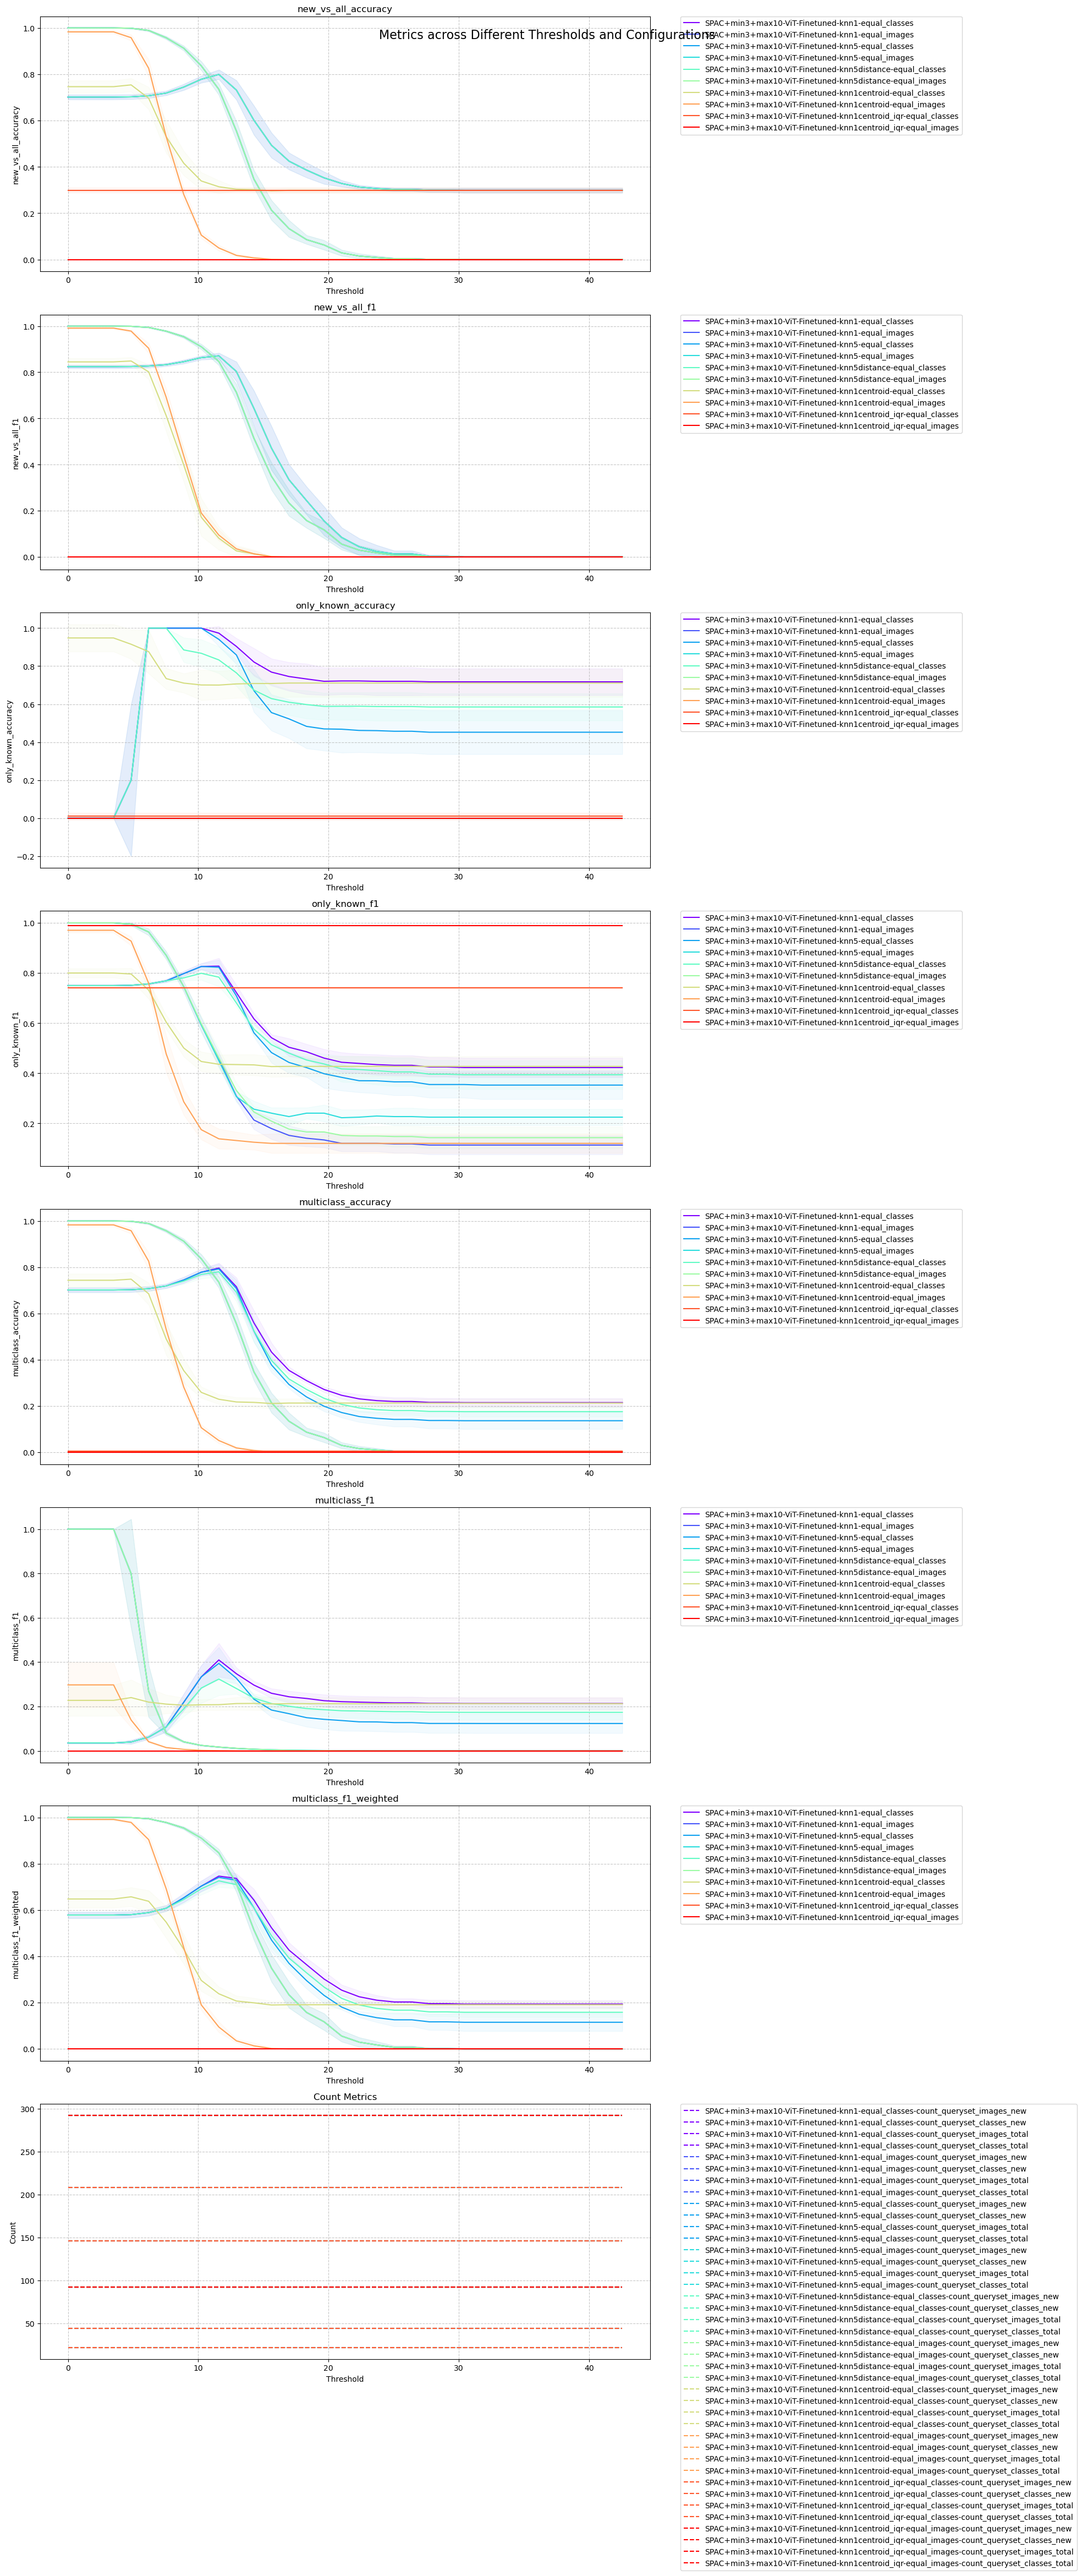

In [160]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple
import math
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import Dict, List, Tuple


def batch_visualize_metrics(results: Dict[Tuple, Dict], configs: List[Tuple]):
    """
    Visualize metrics from cross-validation results for multiple configurations,
    with lighter standard deviation shading.

    Args:
    results (Dict[Tuple, Dict]): Results dictionary from sweep_configs
    configs (List[Tuple]): List of configurations to visualize

    Returns:
    None (displays the plots)
    """
    colors = plt.cm.rainbow(np.linspace(0, 1, len(configs)))

    _one_result = results[configs[0]]["cv_results"]
    metric_names = list(_one_result[list(_one_result.keys())[0]].keys())
    all_metrics = [m for m in metric_names if not m.startswith("count_")]

    num_metrics = len(all_metrics) + 1
    num_cols = 1
    num_rows = math.ceil(num_metrics / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
    fig.suptitle("Metrics across Different Thresholds and Configurations", fontsize=16)

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, metric in enumerate(all_metrics):
        ax = axes[i]

        for config, color in zip(configs, colors):
            dataset, model, labelling_method, construction_method = config
            cv_results = results[config]["cv_results"]
            thresholds = results[config]["thresholds"]

            valid_thresholds = []
            mean_values = []
            std_values = []

            for t in thresholds:
                values = [v for v in cv_results[t][metric] if v is not None]
                if values:
                    valid_thresholds.append(t)
                    mean_values.append(np.mean(values))
                    std_values.append(np.std(values))

            if valid_thresholds:
                ax.plot(
                    valid_thresholds,
                    mean_values,
                    color=color,
                    label=f"{dataset}-{model}-{labelling_method}-{construction_method}",
                )
                ax.fill_between(
                    valid_thresholds,
                    [m - s for m, s in zip(mean_values, std_values)],
                    [m + s for m, s in zip(mean_values, std_values)],
                    alpha=0.05,  # Reduced alpha for lighter shading
                    color=color,
                )

        ax.set_xlabel("Threshold")
        ax.set_ylabel(metric)
        ax.set_title(metric)
        ax.grid(True, linestyle="--", alpha=0.7)
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    # Plot combined count metrics
    ax = axes[len(all_metrics)]
    ax.set_title("Count Metrics")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Count")

    count_metrics = [m for m in metric_names if m.startswith("count_")]

    for config, color in zip(configs, colors):
        dataset, model, labelling_method, construction_method = config
        cv_results = results[config]["cv_results"]
        thresholds = results[config]["thresholds"]

        for metric in count_metrics:
            mean_values = []
            std_values = []

            for t in thresholds:
                values = [v for v in cv_results[t][metric] if v is not None]
                if values:
                    mean_values.append(np.mean(values))
                    std_values.append(np.std(values))
                else:
                    mean_values.append(np.nan)
                    std_values.append(np.nan)

            ax.plot(
                thresholds,
                mean_values,
                color=color,
                linestyle="--",
                label=f"{dataset}-{model}-{labelling_method}-{construction_method}-{metric}",
            )

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    ax.grid(True, linestyle="--", alpha=0.7)

    for i in range(num_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


batch_visualize_metrics(results, partial)